In [21]:
import os
import itertools
import codecs
import re
import datetime
import cairocffi as cairo
import editdistance
import numpy as np
from scipy import ndimage
import pylab
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.layers.recurrent import GRU
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.preprocessing import image
import keras.callbacks
from image_ocr import *

In [22]:
# 動態使用內存

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [78]:
img_h = 64
img_w = 512

words_per_epoch = 16000
val_split = 0.2
val_words = int(words_per_epoch * (val_split))

start_epoch = 20 
stop_epoch = 25 

# Network parameters
conv_filters = 16
kernel_size = (3, 3)
pool_size = 2
time_dense_size = 32
rnn_size = 512
minibatch_size = 32

if K.image_data_format() == 'channels_first':
    input_shape = (1, img_w, img_h)
else:
    input_shape = (img_w, img_h, 1)

fdir = os.path.dirname(get_file('wordlists.tgz',
                                origin='http://www.mythic-ai.com/datasets/wordlists.tgz', untar=True))

img_gen = TextImageGenerator(monogram_file=os.path.join(fdir, 'wordlist_mono_clean.txt'),
                             bigram_file=os.path.join(fdir, 'wordlist_bi_clean.txt'),
                             minibatch_size=minibatch_size,
                             img_w=img_w,
                             img_h=img_h,
                             downsample_factor=(pool_size ** 2),
                             val_split=words_per_epoch - val_words
                             )


In [79]:
act = 'relu'
input_data = Input(name='the_input', shape=input_shape, dtype='float32')
inner = Conv2D(conv_filters, kernel_size, padding='same',
               activation=act, kernel_initializer='he_normal',
               name='conv1')(input_data)
inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
inner = Conv2D(conv_filters, kernel_size, padding='same',
               activation=act, kernel_initializer='he_normal',
               name='conv2')(inner)
inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)

conv_to_rnn_dims = (img_w // (pool_size ** 2), (img_h // (pool_size ** 2)) * conv_filters)
inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

# cuts down input size going into RNN:
inner = Dense(time_dense_size, activation=act, name='dense1')(inner)

# Two layers of bidirectional GRUs
# GRU seems to work as well, if not better than LSTM:
gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(inner)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(inner)
gru1_merged = add([gru_1, gru_1b])
gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

# transforms RNN output to character activations:
inner = Dense(img_gen.get_output_size(), kernel_initializer='he_normal',
              name='dense2')(concatenate([gru_2, gru_2b]))
y_pred = Activation('softmax', name='softmax')(inner)
model = Model(inputs=input_data, outputs=y_pred)

In [80]:
#model, _, _, _ = create_model(input_shape, img_gen, pool_size, img_w, img_h)
model.load_weights("my_model.h5")
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 512, 64, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 512, 64, 16)  160         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 256, 32, 16)  0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 256, 32, 16)  2320        max1[0][0]                       
__________________________________________________________________________________________________
max2 (MaxP

In [85]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.misc import imread, imresize
#use width and height from your neural network here.

def load_for_nn(img_file):
    image = imread(img_file, flatten=True)
    image = imresize(image,(64, img_w)) #(height, width)
    image = image.T

    images = np.ones((1,img_w,64)) #(1,width,height) #change 1 to any number of images you want to predict, here I just want to predict one
    images[0] = image
    images = images[:,:,:,np.newaxis]
    images /= 255

    return images

C:\Users\User\Anaconda3\lib\site-packages\scipy\misc\pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if issubdtype(ts, int):
C:\Users\User\Anaconda3\lib\site-packages\scipy\misc\pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


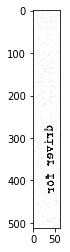

In [102]:
img = load_for_nn('3.png')
plt.imshow(img[0,:,:,0],cmap='gray')

In [103]:
import itertools
alphabet = u'abcdefghijklmnopqrstuvwxyz '
decode = model.predict(img)

In [104]:
def labels_to_text(labels):
    ret = []
    for c in labels:
        if c == len(alphabet):  # CTC Blank
            ret.append("")
        else:
            ret.append(alphabet[c])
    return "".join(ret)

def decode_batch(out):
    # out = test_func([word_batch])[0]
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = labels_to_text(out_best)
        ret.append(outstr)
    return ret

In [105]:
decode_batch(decode)[0]

'd ri ver for'